### <span style="color: green;">Importations</span>

In [2]:
import gymnasium as gym            # Pour l'environnement
import numpy as np                 # Pour les calculs
import matplotlib.pyplot as plt    # Pour les graphes
from collections import deque      # Pour le memory buffer
import random                      # Pour le epsilon greedy
import torch                       # Pour les reseaux de neuronnes et fonction de retropropagation
from torch import nn               #
import torch.nn.functional as F    #
from tqdm import tqdm              # Pour le trace de la barre de progres

<div style="text-align: center;">
    <h1>Algorithme de Deep Q-Network</h1>
</div>

### Classe des reseaux de neuronnes (2 reseaux de neuronnes: Q-training et Q-target)

In [3]:
# Definition d'un reseau de neuronnes
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer 

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x



### Classe du Replay buffer

In [4]:
# Definition du memory buffer
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):   # pour obtenir un echantillon de taille sample_size de la memoire
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

### Classe Environnement

In [5]:
class FrozenLakeDQL():
    
    # Hyperparametres (ajustables)
    learning_rate_a = 0.001         # Facteur d'apprentissage (learning rate, alpha)
    discount_factor_g = 0.9         # Facteur d'actualisation (discount rate, gamma)
    replay_memory_size = 1000       # size of replay memory
    network_sync_rate = 10          # Nombre d'etape que l'agent effectue avant de synchroniser le Q-taining et le Q-target
    mini_batch_size = 32            # Nombre de transitions effectuees et stockees dans le buffer pour constituer un mini-batch 
                                    # apres avoir ete melange
    # Reseaux de Neuronnes
    loss_fn = nn.MSELoss()          # RN: fonction de perte (Loss) MSE=Mean Squared Error 
    optimizer = None                # RN: Optimizer. Initialize later.

    # Pour Print 0,1,2,3 => Left,Down,Right,Up
    ACTIONS = ['Left','Down','Right','Up']    









    # Train dans environment
    def train(self, episodes, render=False, is_slippery=False):
        # Creation de l'environnement 
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n # Nombre d'etats, ici 16
        num_actions = env.action_space.n     # Nombre d'actions possibles, ici 4
        epsilon = 1 # 1 = 100% random actions u depart
        
        # Creation du memory Buffer
        memory = ReplayMemory(self.replay_memory_size) 

        # Creation des reseaux de neuronnes training et target
        training_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) # Le Nombre de noeux dans la couche cachee peut etre adapte 
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)   # mais ici on choisit 16
        # Au demarrage les 2 reseaux de neuronnes sont identiques (copie de biais/poids de training vers target)
        target_dqn.load_state_dict(training_dqn.state_dict())

        # Une copie pour pouvoir comparer par la suite
        print('Training (Remplit au hasard, avant entrainement):') 
        self.print_dqn(training_dqn)

        # l'optimizer du training Network, choisit en Adam mais peut etre change
        self.optimizer = torch.optim.Adam(training_dqn.parameters(), lr=self.learning_rate_a)

        # Liste des recompenses à garder au fil des episodes. Initialisee comme une liste de zeros.
        rewards_per_episode = np.zeros(episodes)
        rewards = 0

        # Liste des epsilones à conserver
        epsilon_history = []

        # Information du nombre d'etapes effectues. Pour synchroniser: Target <= Training
        step_count=0




        ######################################### Training #####################################################
        for i in tqdm(range(episodes), desc="Entraînement"):
            state = env.reset()[0]  # Initialise l'agent a l'etat 0 qui correspond a la case en haut a gauche
            terminated = False      # True quand l'agent tombe dans un trou ou arrive au bout
            truncated = False       # True quand l'agent fait plus de 200 actions (qu'il se perd)   


            ############################## On entre dans la boucle d'un Episode ################################
            # L'agent effectue des transitions jusqu'a qu'il tombe, arrive au bout ou se perde             
            while(not terminated and not truncated):
                
                # 1. L'agent choisit une action selon sa behavior policy qui est ici un epsilon greedy
                if random.random() < epsilon:
                    # Action Aleatoire
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # Action Optimale            
                    with torch.no_grad():
                        action = training_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # 2. Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # 3. Stocker cette transition dans le Replay Buffer
                memory.append((state, action, new_state, reward, terminated)) 

                # 4. Entraîner le réseau si suffisamment d'expériences sont disponibles
                if (len(memory) > self.mini_batch_size):
                    mini_batch = memory.sample(self.mini_batch_size)  # Échantillonnage d'un mini-batch
                    self.optimize(mini_batch, training_dqn, target_dqn)  # Optimisation du réseau
          

                # 5. L'Etat devient le nouvel Etat
                state = new_state
                
                # 6. Incrementation du step counter
                step_count+=1
            #################################### On sort de l'Episode ##########################################

            
            # Stocker la récompense obtenue dans cet épisode
            rewards = rewards + reward
            rewards_per_episode[i] = rewards      

            # Décroître l'epsilon pour favoriser l'exploitation
            epsilon = max(epsilon - 1/episodes, 0)
            epsilon_history.append(epsilon)
            
            # Synchroniser le Target Network avec le Training Network en fonction du network_sync_rate
            if i % self.network_sync_rate == 0:
                target_dqn.load_state_dict(training_dqn.state_dict())
        ########################################################################################################

        # Ferme l'environment
        env.close()

        # Sauvegarder le Training Network
        torch.save(training_dqn.state_dict(), "frozen_lake_dql.pt")


        # Tracer des recompenses (Y-axis) vs Episodes (X-axis)
        plt.plot(rewards_per_episode)
        plt.title("Récompenses par épisode")
        plt.xlabel("Épisode")
        plt.ylabel("Récompense")
        plt.show()
        
        # Tracer Epsilon(Y-axis) vs Episodes (X-axis)
        plt.plot(epsilon_history)
        plt.show()
        












    # Convertion Etatt (int) en un tensor 
    # For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 

    # Parameters: state=1, num_states=16
    # Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor












    
    # Fonction de retropropagation du training Network
    def optimize(self, mini_batch, training_dqn, target_dqn):

        # Get number of input nodes
        num_states = training_dqn.fc1.in_features
        
        current_q_list = []
        target_q_list = []

       
        ######################################## Formule des Deep Q Network ###############################################
        for state, action, new_state, reward, terminated in mini_batch:

            # Get the current set of Q values
            current_q = training_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)


            if terminated: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )
            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)           
        ###################################################################################################################        
        
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()









    

    # RFonction de Test avec la politique apprise
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()




    # PPour afficher un DQN
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%4==0:
                print() # Print a newline every 4 states

## *Main*

Training (Remplit au hasard, avant entrainement):
00,Down,[-0.01 +0.26 +0.09 +0.01] 01,Down,[-0.02 +0.20 +0.10 -0.08] 02,Down,[-0.03 +0.22 +0.13 +0.04] 03,Down,[-0.00 +0.15 +0.12 -0.04] 
04,Down,[-0.01 +0.25 +0.04 +0.01] 05,Right,[+0.06 +0.14 +0.17 +0.07] 06,Right,[+0.04 +0.12 +0.15 -0.04] 07,Down,[-0.02 +0.22 +0.07 -0.02] 
08,Down,[+0.03 +0.13 +0.12 -0.06] 09,Right,[+0.03 +0.12 +0.14 -0.03] 10,Right,[-0.01 +0.17 +0.20 +0.07] 11,Right,[-0.04 +0.16 +0.24 +0.01] 
12,Right,[+0.01 +0.14 +0.22 +0.07] 13,Right,[-0.02 +0.19 +0.20 +0.06] 14,Down,[-0.05 +0.24 +0.14 +0.04] 15,Right,[+0.05 +0.07 +0.15 -0.05] 


Entraînement: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]


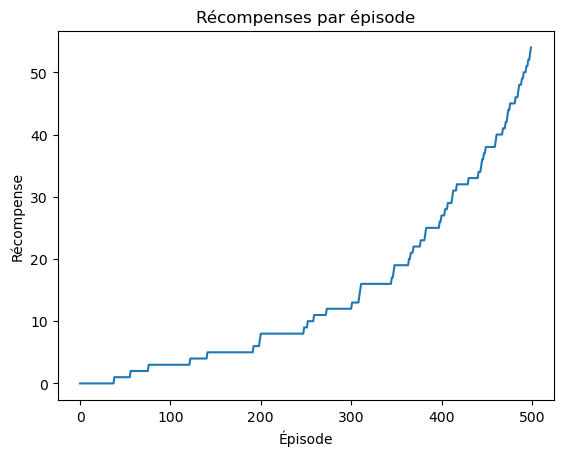

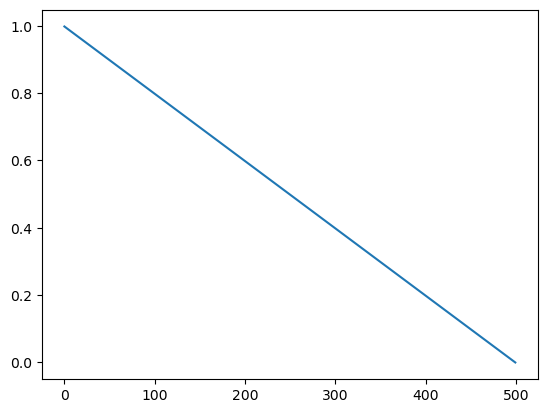

Policy (trained):
00,Left,[+0.08 +0.07 +0.08 +0.08] 01,Up,[+0.05 +0.05 +0.06 +0.07] 02,Right,[+0.08 +0.07 +0.08 +0.07] 03,Up,[+0.04 +0.04 +0.06 +0.06] 
04,Left,[+0.11 +0.06 +0.07 +0.06] 05,Right,[+0.20 +0.16 +0.24 +0.24] 06,Left,[+0.11 +0.05 +0.11 +0.01] 07,Up,[+0.09 +0.10 +0.10 +0.15] 
08,Up,[+0.08 +0.11 +0.09 +0.16] 09,Down,[+0.21 +0.25 +0.16 +0.09] 10,Left,[+0.29 +0.23 +0.14 +0.11] 11,Right,[+0.14 +0.22 +0.30 +0.15] 
12,Right,[+0.13 +0.16 +0.30 +0.21] 13,Right,[+0.24 +0.37 +0.42 +0.25] 14,Down,[+0.49 +0.62 +0.62 +0.55] 15,Left,[+0.10 +0.05 +0.10 +0.08] 


In [6]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = True
    frozen_lake.train(500, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)